## How much tracer is there on the shelf?

This notebook explores the effects of changing the initial tracer profile on the total amount of tracer (mass) on the shelf at a certain time and place.

In [2]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [4]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
#Exp
CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
#CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.

CGridOut = Dataset(CGrid)


In [6]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CGrid,'dxG')



In [15]:
def get_iniProfile(exp, run, TrNum, key):
    '''Get column from the pandas dataframe containing initial profiles using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI), TrNum (1,2,3, etc). All input variables are strings.
    Returns the desired column from the dataframe.'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%siniTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col

def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [19]:
# load initial profiles

tracers = ['1','2','3','4','5','6','7','8']

IniP = np.zeros((nz,len(tracers))) 
TotalTr = np.zeros((nt,len(tracers))) 
TotalHCW = np.zeros((nt,len(tracers)))
TotalTrNoC = np.zeros((nt,len(tracers))) 
TotalHCWNoC = np.zeros((nt,len(tracers))) 

kk = 0

for ii in tracers:
    
    IniP[:,kk] = get_iniProfile('BAR', '01', ii,'IniProfile' )
    TotalTr[:,kk] = get_metrics('BAR', '01', ii,'TronShelf' )
    TotalHCW[:,kk] = get_metrics('BAR', '01', ii,'HCWonShelf' )
    TotalTrNoC[:,kk] = get_metrics('BAR', '02', ii,'TronShelf' )
    TotalHCWNoC[:,kk] = get_metrics('BAR', '02', ii,'HCWonShelf' )
    
    kk=kk+1



### Tracer mass and water with concentration equal or higher than at SB on shelf (HCW)

Tracer mass normalized by initial mass on shelf for each run. HCW normalized by shelf volume. This volume is smaller for no canyon case. The volume is the initial volume of HCW for oxygen, since all the water on the shelf has an oxygen concentration higher than at SB because the profile decreases exponentially with depth.

The shelf here is defined as the complete box on tol of the shelf, from surface to bottom, including the space on top of the canyon.

In [29]:
volShelfBox = TotalHCW[0,2] # the third tr is oxygen so index 2.
volShelfBoxNoC = TotalHCWNoC[0,2]

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


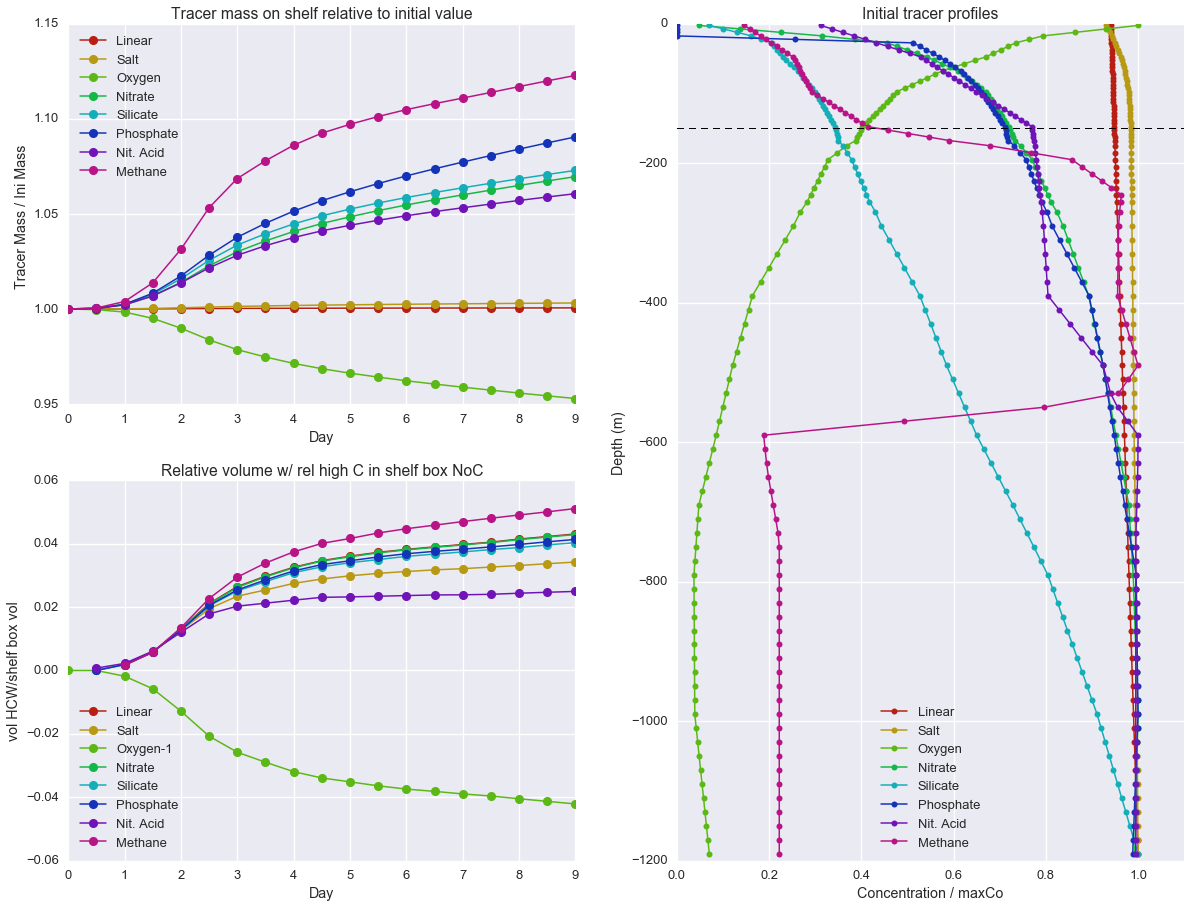

In [36]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(8):
    ax1 = plt.subplot(2,2,1)
    ax1.plot(times/2.0, TotalTr[:,tr]/TotalTr[0,tr],'o-', label=labels[tr])
    plt.ylabel('Tracer Mass / Ini Mass ')
    plt.xlabel('Day')
    plt.title('Tracer mass on shelf relative to initial value')

    ax2 = plt.subplot(2,2,3)
    if tr == 2:
        ax2.plot(times/2.0, (TotalHCW[:,tr]/volShelfBox)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax2.plot(times/2.0, (TotalHCW[:,tr]/volShelfBox),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('vol HCW/shelf box vol')
    plt.xlabel('Day')

    ax3 = plt.subplot(2,2,(2,4))
    ax3.plot(IniP[:,tr]/np.max(IniP[:,tr]),rc[:],'o-',markersize = 6, label=labels[tr])
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)
   



#fig45.savefig('figures/TrOnShelfBoxBARrun01.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


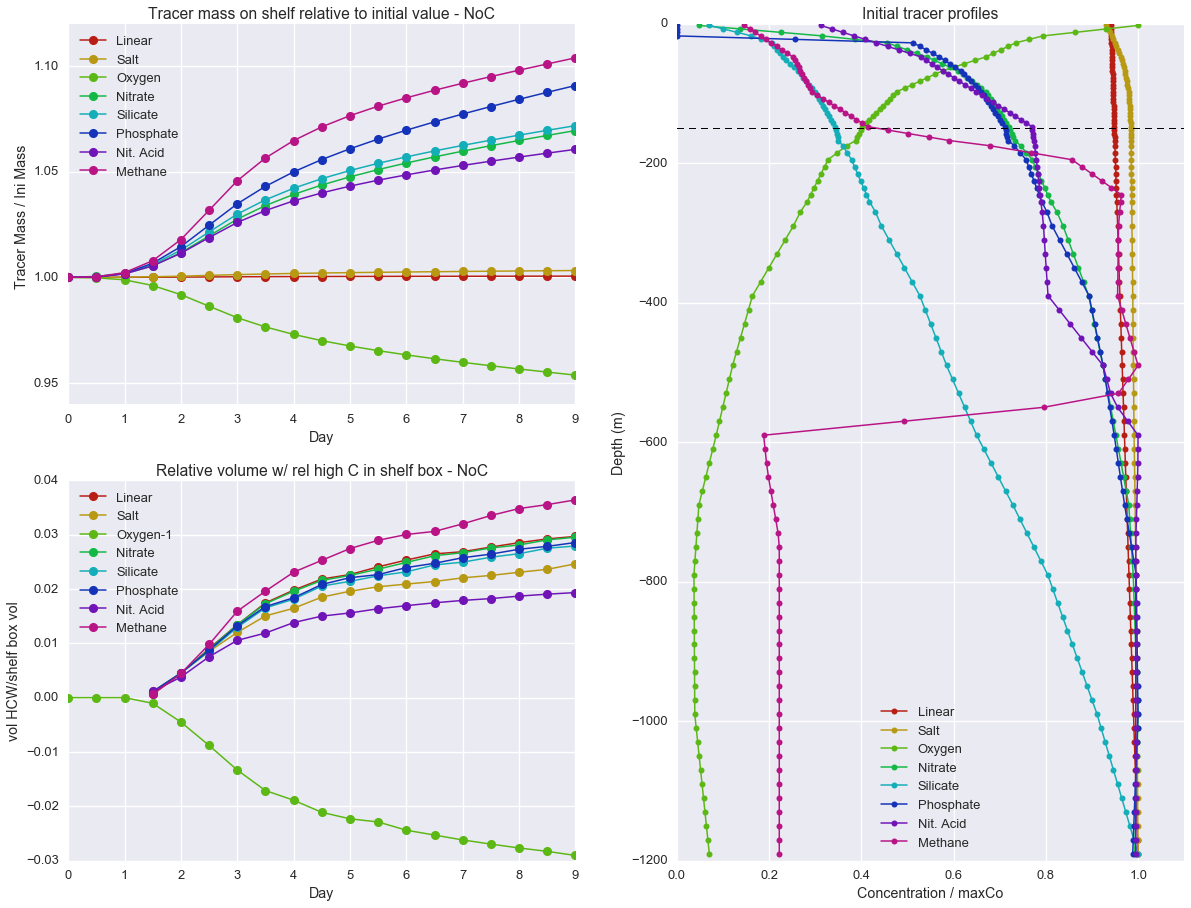

In [38]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(8):
    ax1 = plt.subplot(2,2,1)
    ax1.plot(times/2.0, TotalTrNoC[:,tr]/TotalTrNoC[0,tr],'o-', label=labels[tr])
    plt.ylabel('Tracer Mass / Ini Mass ')
    plt.xlabel('Day')
    plt.title('Tracer mass on shelf relative to initial value - NoC')

    ax2 = plt.subplot(2,2,3)
    if tr == 2:
        ax2.plot(times/2.0, (TotalHCWNoC[:,tr]/volShelfBoxNoC)-1,'o-', label=('%s-1' %labels[tr] ))
    else:
        ax2.plot(times/2.0, (TotalHCWNoC[:,tr]/volShelfBoxNoC),'o-', label=labels[tr])
    plt.title('Relative volume w/ rel high C in shelf box - NoC')
    plt.ylabel('vol HCW/shelf box vol')
    plt.xlabel('Day')

    ax3 = plt.subplot(2,2,(2,4))
    ax3.plot(IniP[:,tr]/np.max(IniP[:,tr]),rc[:],'o-',markersize = 6, label=labels[tr])
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)
   



#fig45.savefig('figures/TrOnShelfBoxBARrun02.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


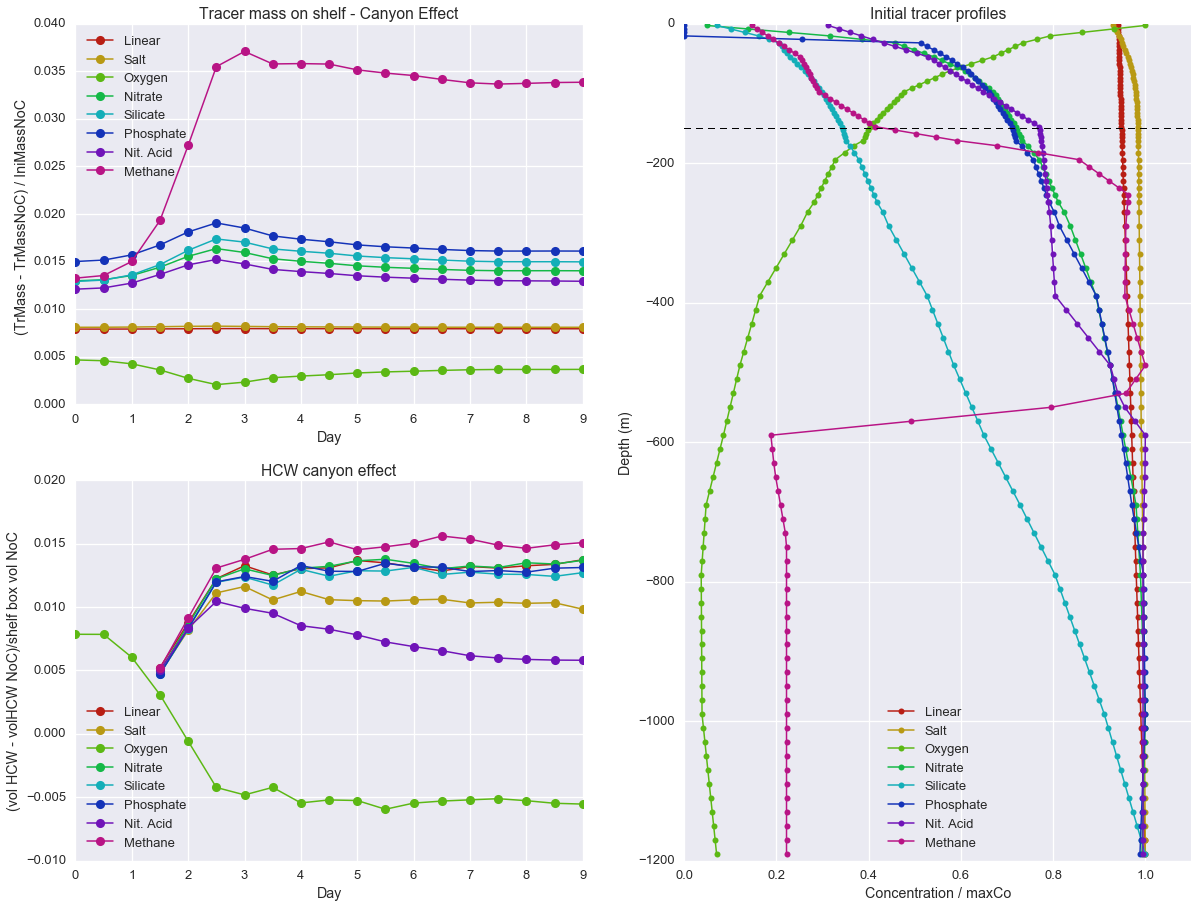

In [43]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

for tr in range(8):
    ax1 = plt.subplot(2,2,1)
    ax1.plot(times/2.0, (TotalTr[:,tr]-TotalTrNoC[:,tr])/(TotalTrNoC[0,tr]),'o-', label=labels[tr])
    plt.ylabel('(TrMass - TrMassNoC) / IniMassNoC ')
    plt.xlabel('Day')
    plt.title('Tracer mass on shelf - Canyon Effect')

    ax2 = plt.subplot(2,2,3)
    ax2.plot(times/2.0, (TotalHCW[:,tr]-TotalHCWNoC[:,tr])/(volShelfBoxNoC),'o-', label=labels[tr])
    plt.title('HCW canyon effect')
    plt.ylabel('(vol HCW - volHCW NoC)/shelf box vol NoC')
    plt.xlabel('Day')

    ax3 = plt.subplot(2,2,(2,4))
    ax3.plot(IniP[:,tr]/np.max(IniP[:,tr]),rc[:],'o-',markersize = 6, label=labels[tr])
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)
   



#fig45.savefig('figures/TrOnShelfBoxBARrun02.eps', format='eps', dpi=1000, bbox_inches='tight')

        

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


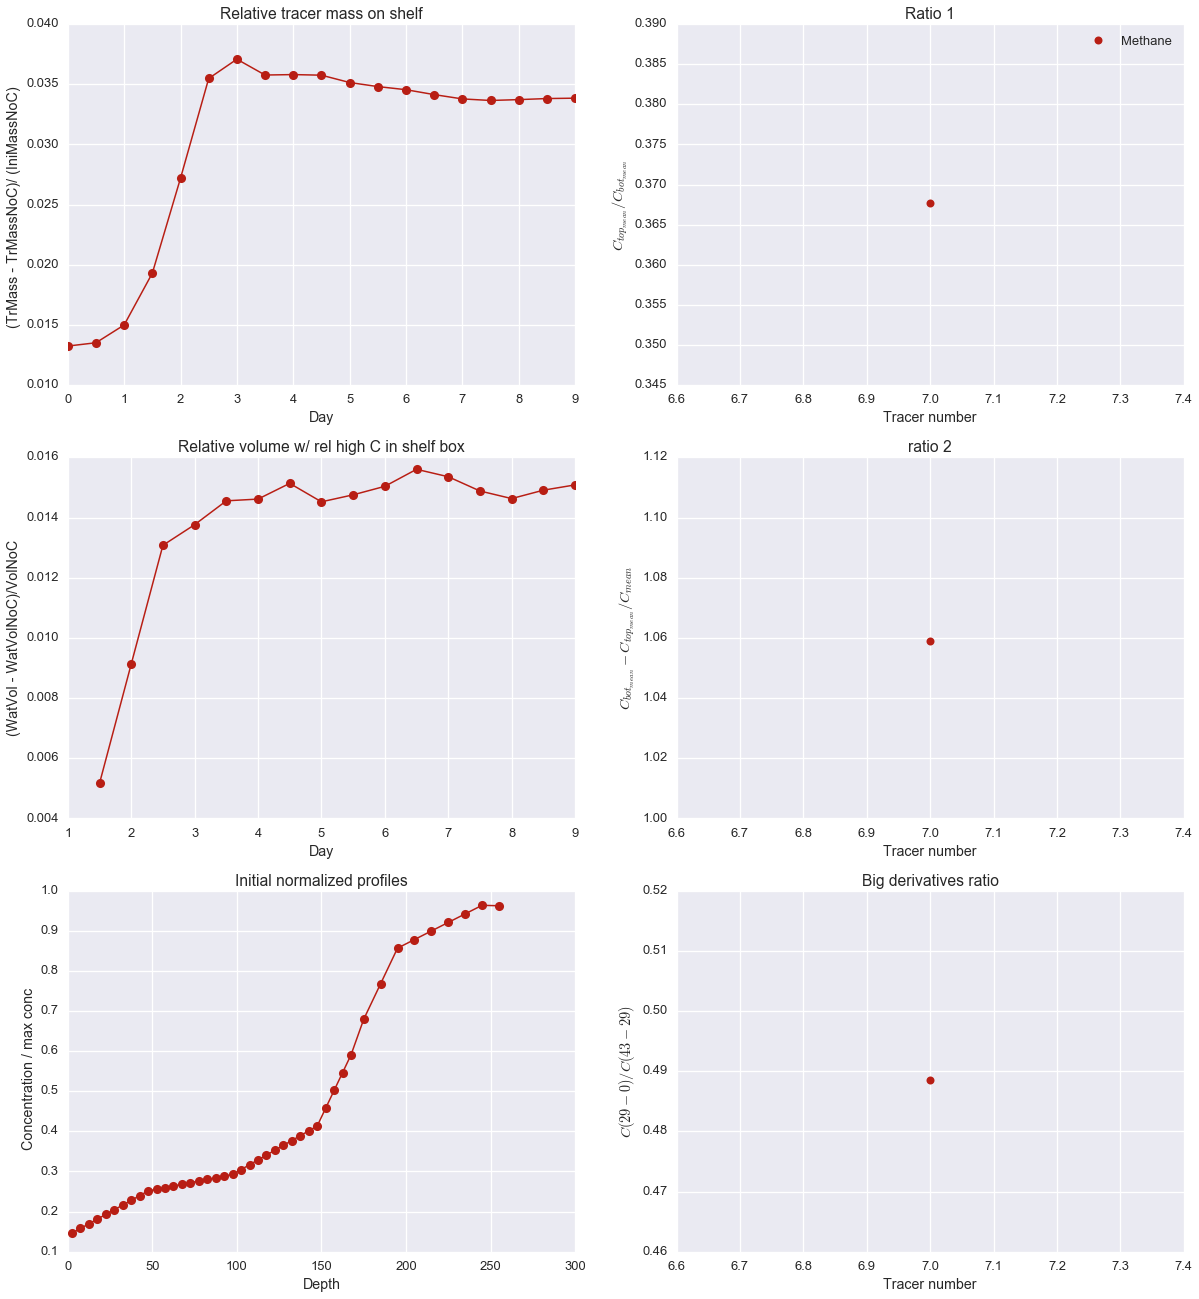

In [56]:
fig45=plt.figure(figsize=(20,22))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

sns.set_palette( sns.hls_palette(8, l=.4, s=.8))  

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

for tr in range(8):
    
    ax1 = plt.subplot2grid((3,2), (0,0), colspan=1,rowspan=1)
    
    ax1.plot(times/2.0, (TotalTr[:,tr]-TotalTrNoC[:,tr])/(TotalTrNoC[0,tr]),'o-', label=labels[tr])
    
    plt.ylabel('(TrMass - TrMassNoC)/ (IniMassNoC) ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
    
    ax2 = plt.subplot2grid((3,2), (2,0), colspan=1,rowspan=1)
    
    ax2.plot(-rc[0:43], IniP[0:43,tr]/np.max(IniP[:,tr]) ,'o-', label=labels[tr])
    
    plt.ylabel(' Concentration / max conc')
    plt.xlabel('Depth')
    plt.title('Initial normalized profiles')

    
    ax3 = plt.subplot2grid((3,2), (1,0))

    ax3.plot(times/2.0, (TotalHCW[:,tr]-TotalHCWNoC[:,tr])/volShelfBoxNoC,'o-',label=labels[tr])
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('(WatVol - WatVolNoC)/VolNoC')
    plt.xlabel('Day')

    
    ax5 = plt.subplot2grid((3,2), (0,1), colspan=1,rowspan=1)
    
    ax5.plot(tr,(np.mean(IniP[0:29,tr])/np.mean(IniP[29:43,tr])),'o',markersize = 8, label=labels[tr])
    
    plt.title('Ratio 1')
    
    plt.ylabel('$C_{top_{mean}}/C_{bot_{mean}}$')
    plt.xlabel('Tracer number')
    
     
    ax6 = plt.subplot2grid((3,2), (2,1), colspan=1,rowspan=1)
    
    ax6.plot(tr,(IniP[29,tr]-IniP[0,tr])/(IniP[43,tr]-IniP[29,tr]),'o',markersize = 8, label=labels[tr])
     
    plt.title('Big derivatives ratio')
    plt.ylabel('$C(29-0)/C(43-29)$')
    plt.xlabel('Tracer number')
    
    ax7 = plt.subplot2grid((3,2), (1,1), colspan=1,rowspan=1)
    
    ax7.plot(tr,(-np.mean(IniP[0:29,tr])+np.mean(IniP[29:43,tr]))/np.mean(IniP[:,tr]),'o',markersize = 8, label=labels[tr])
     
    #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('ratio 2')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$C_{bot_{mean}}-C_{top_{mean}}/C_{mean}$')
    plt.xlabel('Tracer number')
    
        
#plt.tight_layout()

handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')
